In [ ]:
! unzip "/content/drive/MyDrive/brain_breast_tumer/Dataset.zip" -d "/content/drive/MyDrive/brain_breast_tumer"

unzip:  cannot find or open https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip, https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip.zip or https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip.ZIP.


In [ ]:
import tensorflow.keras as k
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns08
import tensorflow as tf
import cv2
import pathlib
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils


# creat the data set 

In [ ]:
!rm -r /content/drive/MyDrive/brain_breast_tumer/classification_1


In [ ]:
!rm -r /content/dataset
! unzip /content/drive/MyDrive/brain_breast_tumer/Dataset.zip -d /content/dataset

In [ ]:
# import os 
# ! mkdir "/content/drive/MyDrive/brain_breast_tumer/classification_1/val/brain"


In [ ]:
## train 
# brain 
#!mv /content/Dataset/Dataset/Brainscans/Tumor/TRAIN/*  /content/drive/MyDrive/brain_breast_tumer/classification_1/train/brain/
#!mv /content/Dataset/Dataset/Brainscans/Notumor/Train/*  /content/drive/MyDrive/brain_breast_tumer/classification_1/train/brain/
# # breast 
#!mv /content/Dataset/Dataset/Breastscans/benign/Train/*  /content/drive/MyDrive/brain_breast_tumer/classification_1/train/breast/
#!mv /content/Dataset/Dataset/Breastscans/malignant/Train/*  /content/drive/MyDrive/brain_breast_tumer/classification_1/train/breast/
#!mv /content/Dataset/Dataset/Breastscans/normal/Train/* /content/drive/MyDrive/brain_breast_tumer/classification_1/train/breast/


# # val
# # brain 
#!mv /content/Dataset/Dataset/Brainscans/Tumor/TEST/*  /content/drive/MyDrive/brain_breast_tumer/classification_1/val/brain/
#!mv /content/Dataset/Dataset/Brainscans/Notumor/Test/*  /content/drive/MyDrive/brain_breast_tumer/classification_1/val/brain/
# # breast 
#!mv /content/Dataset/Dataset/Breastscans/benign/Test/*  /content/drive/MyDrive/brain_breast_tumer/classification_1/val/breast/
#!mv /content/Dataset/Dataset/Breastscans/malignant/Test/* /content/drive/MyDrive/brain_breast_tumer/classification_1/val/breast/
#!mv /content/Dataset/Dataset/Breastscans/normal/Test/*  /content/drive/MyDrive/brain_breast_tumer/classification_1/val/breast/



# split the dataset

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)

In [ ]:
train_dir = "/content/drive/MyDrive/brain_breast_tumer/classification_1/train"
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2275 files belonging to 2 classes.


In [ ]:
test_dir = "/content/drive/MyDrive/brain_breast_tumer/classification_1/test"
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 370 files belonging to 2 classes.


As the original dataset doesn't contain a validation set, you will create one. To do so, determine how many batches of data are available in the train set using tf.data.experimental.cardinality, then move 20% of them to a val set.

In [ ]:
train_batches = tf.data.experimental.cardinality(train_dataset)
#test_dataset = train_dataset.take(train_batches // 5)
validation_dataset = train_dataset.skip(train_batches // 5)

## visualize imgs

KeyboardInterrupt: ignored

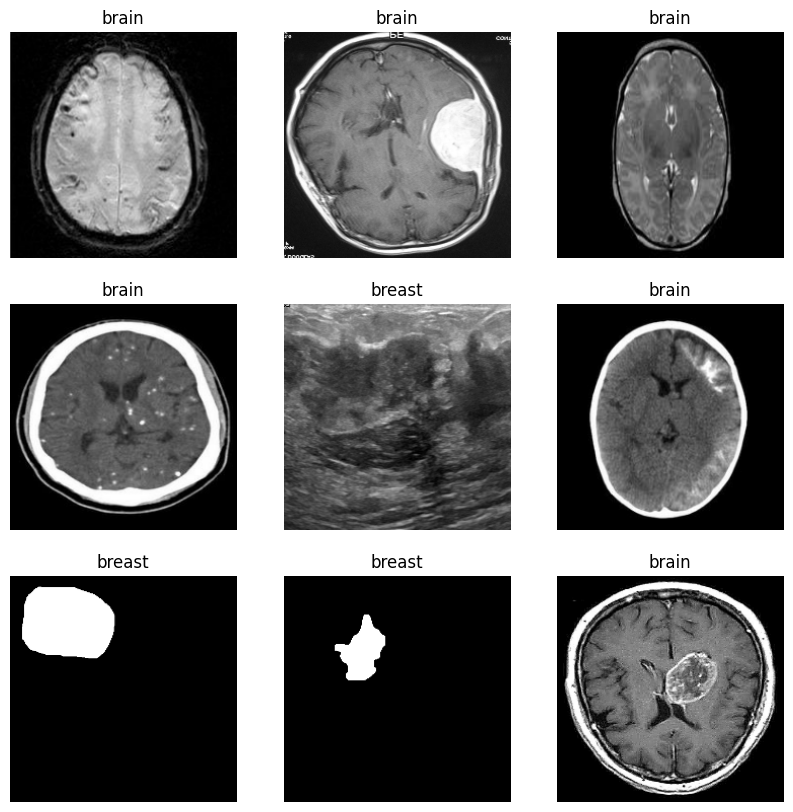

In [ ]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(40):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# base_model

Rescale pixel values
In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

This feature extractor converts each 224x224x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.




In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.




In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.



In [ ]:

inputs = tf.keras.Input(shape=(224, 224, 3))
base_model.trainable = False
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Compile the model
Compile the model before training it. Since there are two classes, use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.




In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["Accuracy","Recall","Precision"])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [ ]:
loss0, accuracy0,recall0,precision0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

58/58 [==============================] - 11s 126ms/step - loss: 0.6359 - Accuracy: 0.6054 - recall: 0.3742 - precision: 0.8435
initial loss: 0.64
initial accuracy: 0.61


In [ ]:
history = model.fit(train_dataset,
                    epochs=3,
                    validation_data=validation_dataset)

Epoch 1/3
72/72 [==============================] - 23s 273ms/step - loss: 0.4370 - Accuracy: 0.7824 - recall: 0.6695 - precision: 0.9202 - val_loss: 0.2373 - val_Accuracy: 0.9737 - val_recall: 0.9565 - val_precision: 0.9970
Epoch 2/3
72/72 [==============================] - 20s 265ms/step - loss: 0.1843 - Accuracy: 0.9767 - recall: 0.9631 - precision: 0.9951 - val_loss: 0.1155 - val_Accuracy: 0.9995 - val_recall: 0.9990 - val_precision: 1.0000
Epoch 3/3
72/72 [==============================] - 18s 242ms/step - loss: 0.1013 - Accuracy: 0.9952 - recall: 0.9914 - precision: 1.0000 - val_loss: 0.0705 - val_Accuracy: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000


In [ ]:
history.history['accuracy']


[0.590329647064209, 0.9248351454734802, 0.9894505739212036]

# evaluation

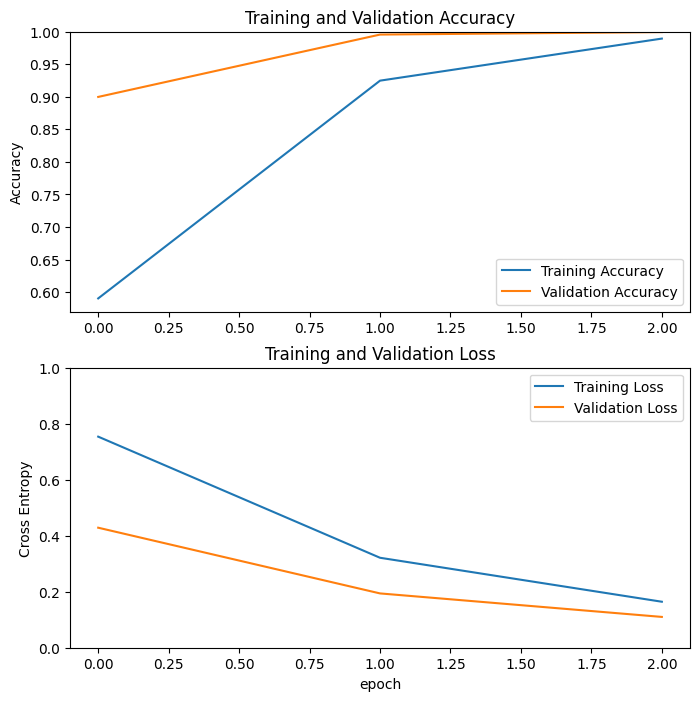

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy,percision,recall = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

14/14 [==============================] - 3s 121ms/step - loss: 0.0725 - Accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000
Test accuracy : 1.0


Predictions:
 [0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 1]
Labels:
 [0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 1]


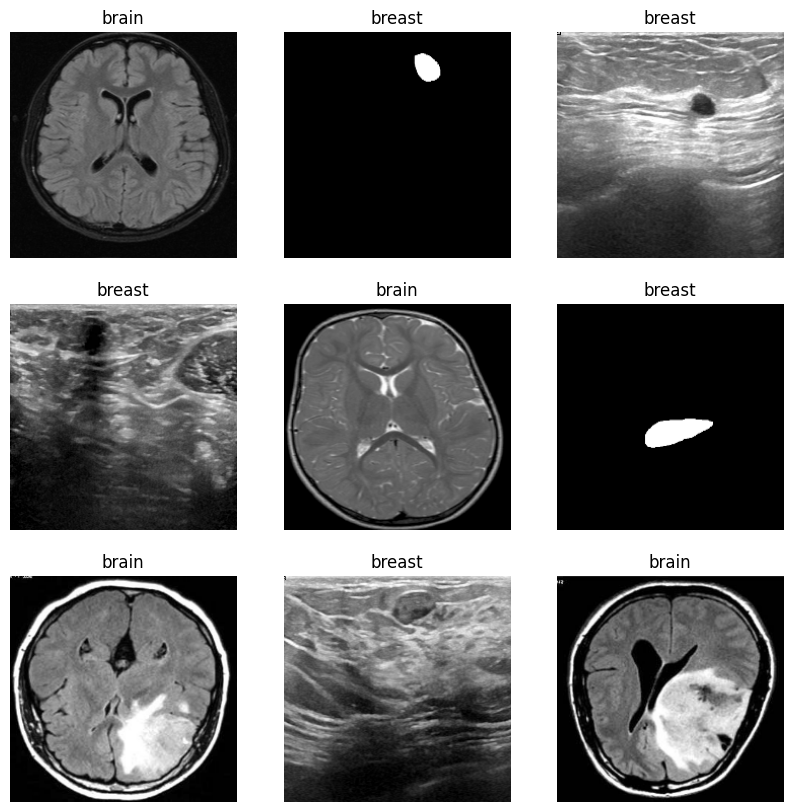

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# SAVE THE MODEL

In [ ]:
export_path = "/content/drive/MyDrive/brain_breast_tumer/classification_1"
model.save(export_path)

export_path

'/content/drive/MyDrive/brain_breast_tumer/classification_1'

In [ ]:
from tensorflow.keras.models import load_model
model_loaded =tf.keras.models.load_model("/content/drive/MyDrive/brain_breast_tumer/classification_1/train/final_model")

In [ ]:
model_loaded.summary()
base_learning_rate = 0.0001
model_loaded.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [ ]:
img = cv2.imread("/content/drive/MyDrive/brain_breast_tumer/classification_1/train/brain/No12.jpg")
img = cv2.resize(img, (224,224))
img.shape
#model_loaded.predict(img)

(224, 224, 3)

In [ ]:
classes = ["brain","breast"]
imagePath = "/content/drive/MyDrive/brain_breast_tumer/classification_1/train/breast/benign (1).png"
test_image = image.load_img(imagePath, target_size = (224, 224)) 
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

#predict the result
result = model_loaded.predict(test_image)
#results = imagenet_utils.decode_predictions(result)
predictions = tf.nn.sigmoid(result)
predictions = tf.where(predictions < 0.5, 0, 1)
predictions = predictions.numpy()
predictions

1/1 [==============================] - 0s 112ms/step


array([[1]], dtype=int32)

In [ ]:
#classes[predictions[0]]
classes[predictions[0][0]]

'breast'

In [ ]:
predictions[0]


<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>

# breast 

In [ ]:
dataset_url = "/content/drive/MyDrive/brain_breast_tumer/Dataset/Breast scans"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

ValueError: ignored

# trails

In [ ]:
img = tf.io.read_file("/content/drive/MyDrive/brain_breast_tumer/Dataset/Brain scans/Tumor/TEST/y701.jpg")

In [ ]:
img = tf.image.decode_jpeg(img, channels=1)

In [ ]:
img_2 = cv2.imread("/content/drive/MyDrive/brain_breast_tumer/Dataset/Brain scans/Tumor/TEST/y701.jpg",0)

In [ ]:
img_2

array([[6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       ...,
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6]], dtype=uint8)

In [ ]:
import matplotlib.pyplot as plt


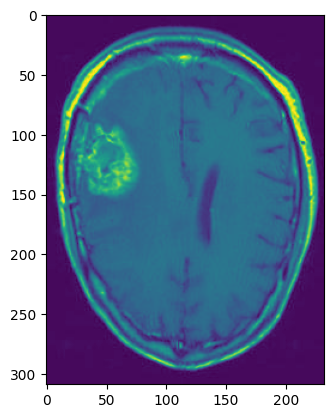

In [ ]:
plt.imshow(img_2)